In [26]:
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.io_utils as io_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.misc.cpg_const as cpg_const
from matching.glema.common.model import InferenceGNN
from matching.glema.common.utils.plot_utils import ColorScheme

In [27]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "CPG_augm_large"
#args.dataset = "dpdf"
args.directed = True
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )
result_dir = os.path.join( args.result_dir, model_name )

args = arg_utils.load_args( args, model_name )
args.iso = True
args.test_data = True

In [28]:
DESIGN_PATTERN_MAPPING = {
    #cpg_const.DesignPatternType.ABSTRACT_FACTORY.value: "Abstract Factory",
    cpg_const.DesignPatternType.ADAPTER.value: "Adapter",
    cpg_const.DesignPatternType.BUILDER.value: "Builder",
    #cpg_const.DesignPatternType.FACADE.value: "Facade",
    cpg_const.DesignPatternType.FACTORY_METHOD.value: "Factory Method",
    cpg_const.DesignPatternType.OBSERVER.value: "Observer",
    cpg_const.DesignPatternType.SINGLETON.value: "Singleton",
    cpg_const.DesignPatternType.DECORATOR.value: "Decorator",
    #cpg_const.DesignPatternType.MEMENTO.value: "Memento",
    #cpg_const.DesignPatternType.PROTOTYPE.value: "Prototype",
    #cpg_const.DesignPatternType.PROXY.value: "Proxy",
    #cpg_const.DesignPatternType.VISITOR.value: "Visitor",
    #cpg_const.NO_DESIGN_PATTERN: "None",
}

matching_colors = {
    2: ColorScheme.HIGHLIGHT,
    1: ColorScheme.SECONDARY,
    0: "grey",
    -1: ColorScheme.SECONDARY_COMP
}

color_legend = {
    matching_colors[2]: "Anchor",
    matching_colors[1]: "Iso",
    matching_colors[-1]: "Non-Iso",
    matching_colors[0]: "Node",
}

NONE_TYPE = " "

In [29]:
matching_examples_file = io_utils.get_abs_file_path( os.path.join( result_dir, "matching_examples.pkl" ) )
with open( matching_examples_file, 'rb' ) as handle:
    matching_examples: dict[ tuple[ str, str ], dict[ str, any ] ] = pickle.load( handle )
matching_examples.keys()

dict_keys([('ADAPTER', 'ADAPTER'), ('BUILDER', 'BUILDER'), ('FACTORY_METHOD', 'FACTORY_METHOD'), ('OBSERVER', 'OBSERVER'), ('SINGLETON', 'SINGLETON'), ('DECORATOR', 'DECORATOR'), ('ADAPTER', 'BUILDER'), ('ADAPTER', 'FACTORY_METHOD'), ('ADAPTER', 'OBSERVER'), ('ADAPTER', 'SINGLETON'), ('ADAPTER', 'DECORATOR'), ('BUILDER', 'ADAPTER'), ('BUILDER', 'FACTORY_METHOD'), ('BUILDER', 'OBSERVER'), ('BUILDER', 'SINGLETON'), ('BUILDER', 'DECORATOR'), ('FACTORY_METHOD', 'ADAPTER'), ('FACTORY_METHOD', 'BUILDER'), ('FACTORY_METHOD', 'OBSERVER'), ('FACTORY_METHOD', 'SINGLETON'), ('FACTORY_METHOD', 'DECORATOR'), ('OBSERVER', 'ADAPTER'), ('OBSERVER', 'BUILDER'), ('OBSERVER', 'FACTORY_METHOD'), ('OBSERVER', 'SINGLETON'), ('OBSERVER', 'DECORATOR'), ('SINGLETON', 'ADAPTER'), ('SINGLETON', 'BUILDER'), ('SINGLETON', 'FACTORY_METHOD'), ('SINGLETON', 'OBSERVER'), ('SINGLETON', 'DECORATOR'), ('DECORATOR', 'ADAPTER'), ('DECORATOR', 'BUILDER'), ('DECORATOR', 'FACTORY_METHOD'), ('DECORATOR', 'OBSERVER'), ('DECORAT

In [30]:
for (source_type, query_type), example in matching_examples.items():
    matched, node_colors, edge_colors = graph_utils.combine_normalized( example[ "source" ], 
                                                                        example[ "query" ],
                                                                        matching_colors=matching_colors )
    example[ "matched" ] = matched
    example[ "node_colors" ] = node_colors
    example[ "edge_colors" ] = edge_colors
    
raw_type_examples = {}
for (source_type, query_type), example in matching_examples.items():
    if (source_type, NONE_TYPE) not in raw_type_examples:
        raw_type_examples[(source_type, NONE_TYPE)] = {
            "matched": example[ "source" ],
            "node_colors": graph_utils.get_node_colors( example[ "source" ], 
                                                        anchor_color=matching_colors[2],
                                                        node_color=matching_colors[0] ),
            "edge_colors": matching_colors[0]
        }
    if (NONE_TYPE, query_type) not in raw_type_examples:
        raw_type_examples[(NONE_TYPE, query_type)] = {
            "matched": example[ "query" ],
            "node_colors": graph_utils.get_node_colors( example[ "query" ], 
                                                        anchor_color=matching_colors[2],
                                                        node_color=matching_colors[0] ),
            "edge_colors": matching_colors[0]
        }
        
for type, example in raw_type_examples.items():
    matching_examples[ type ] = example

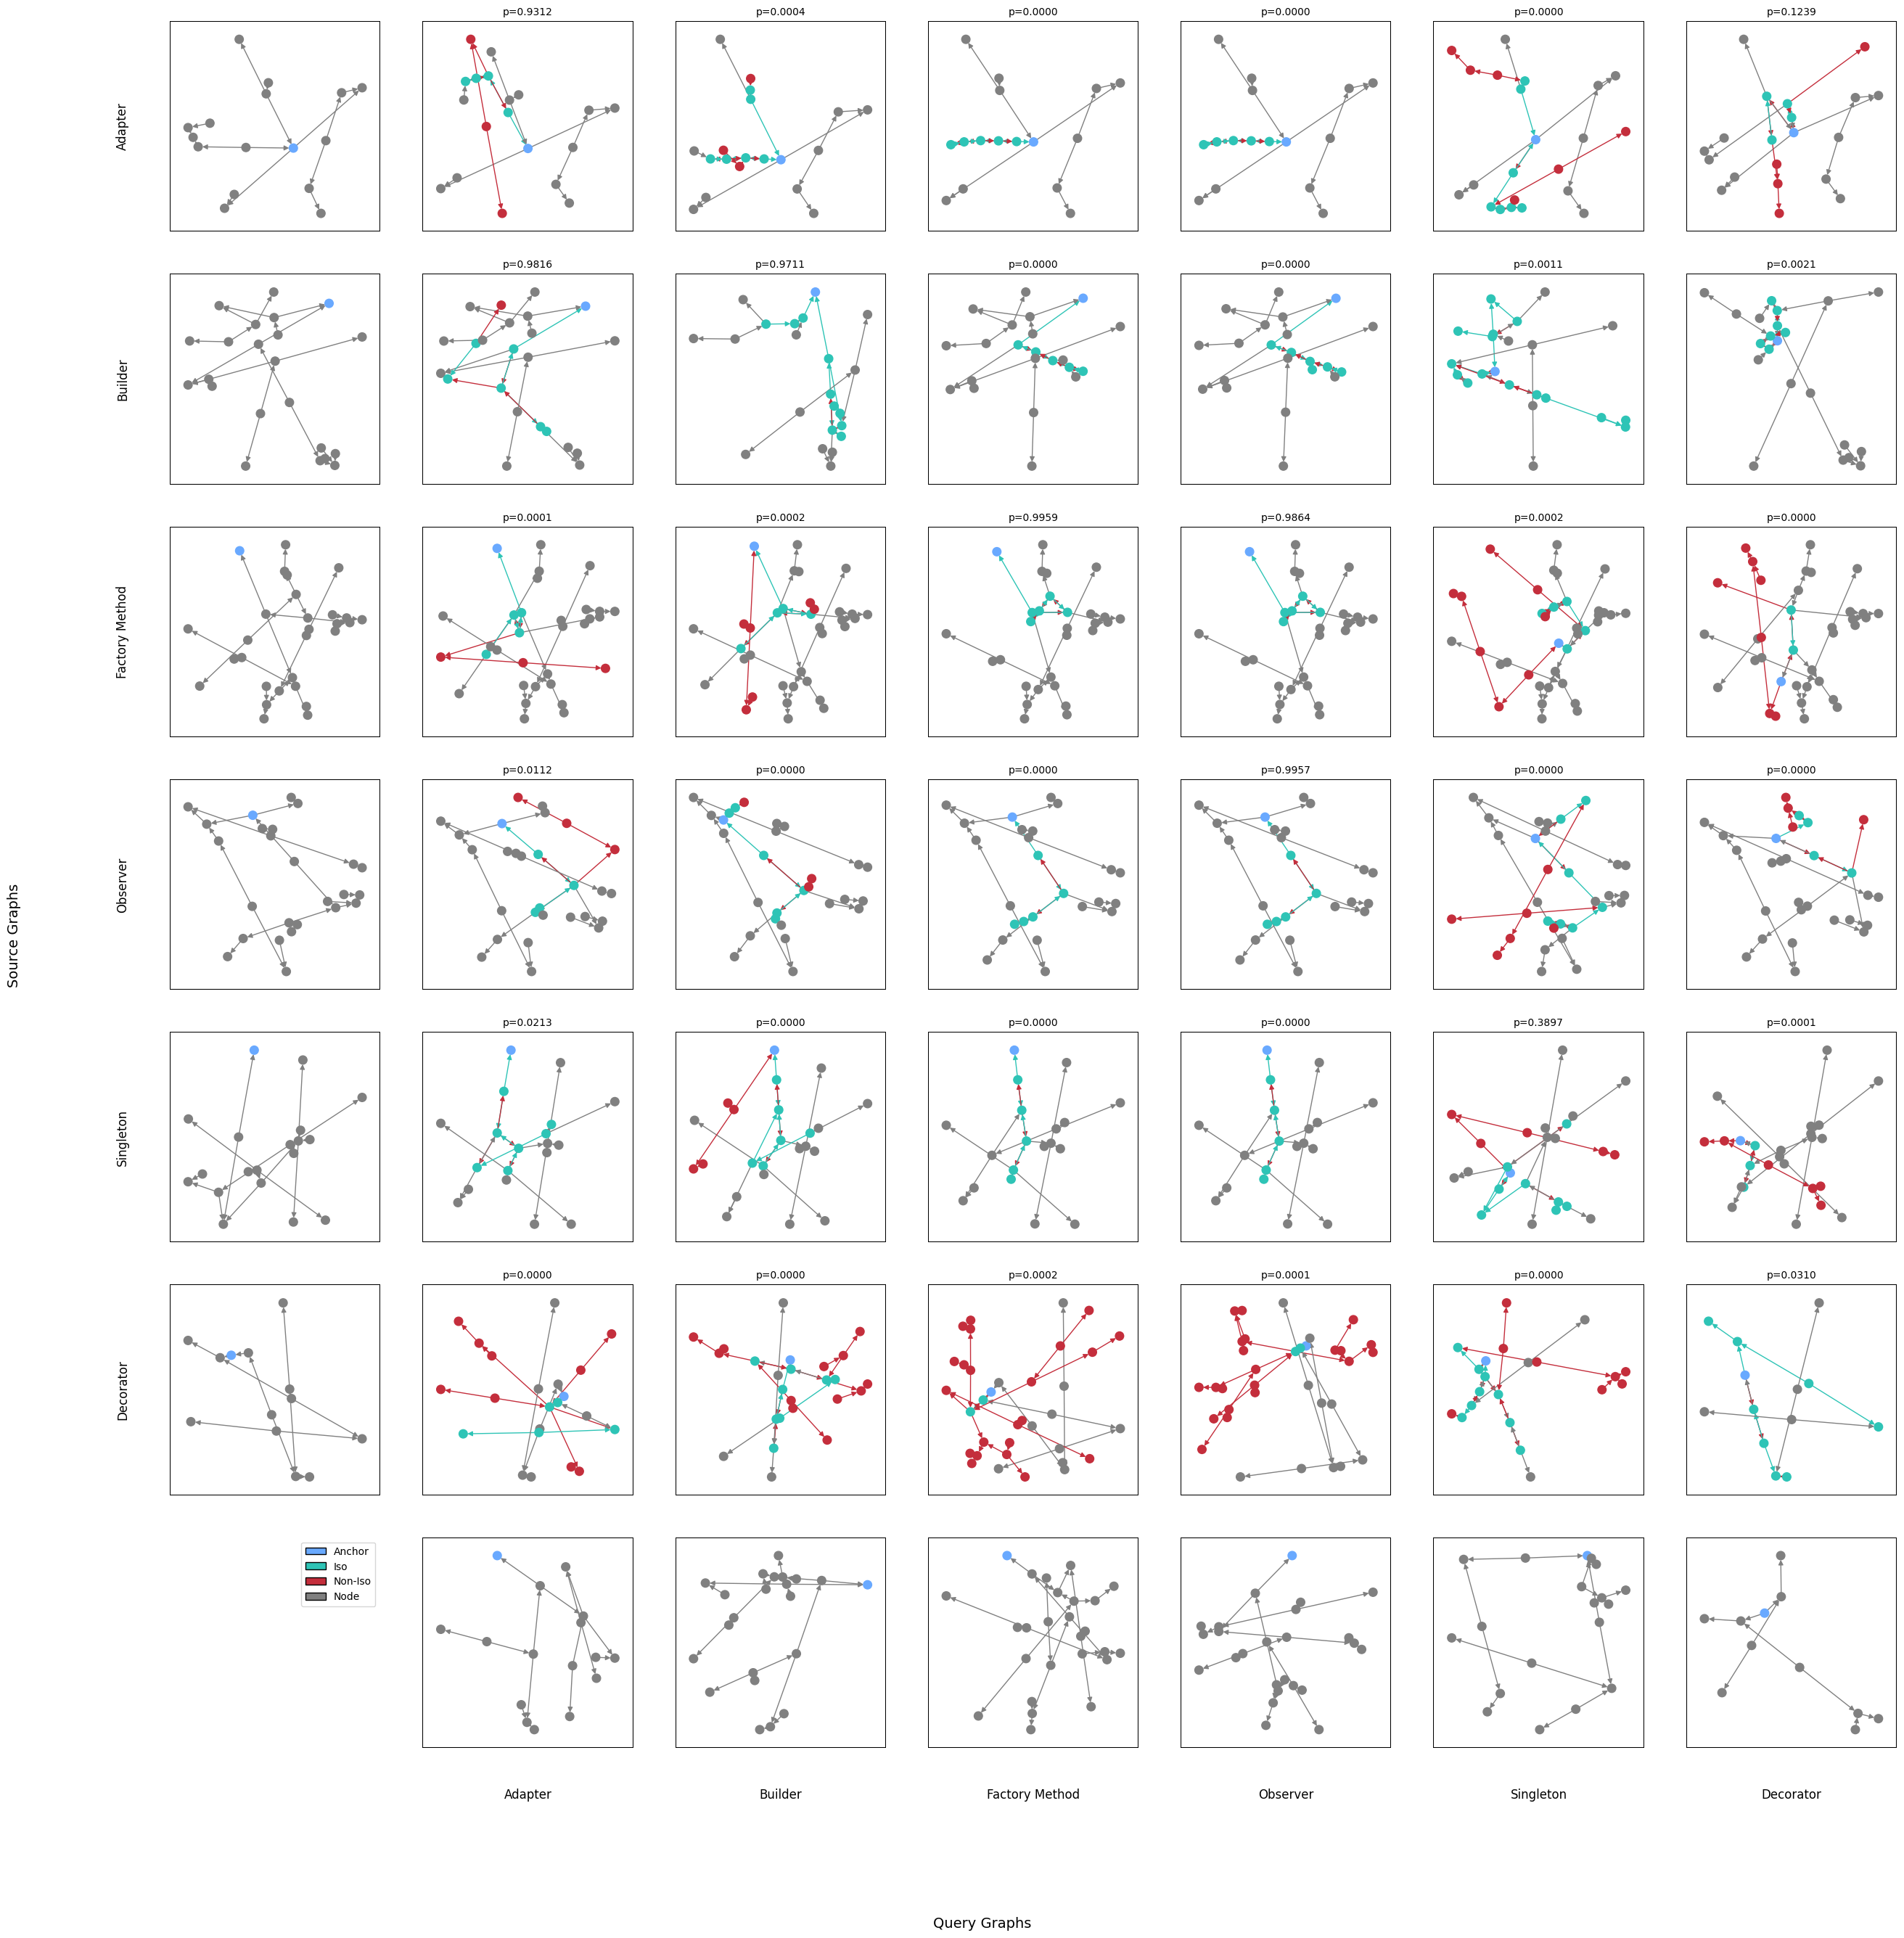

In [31]:
def plot_graph_matching( graph_types: list[ str ],
                         graph_matching_examples: dict,
                         color_legend: dict[ str, str ] = None,
                         save_name=None ):
    n = len( graph_types ) + 1
    fig, axes = plt.subplots( n, n, figsize=(4 * n, 4 * n) )

    # Ensure axes is 2D even for a single plot.
    if n == 1:
        axes = [ [ axes ] ]

    x_graph_type = [ NONE_TYPE, *graph_types ]
    y_graph_type = [ *graph_types, NONE_TYPE ]

    # Loop over each cell.
    for i, source in enumerate( y_graph_type ):
        for j, query in enumerate( x_graph_type ):
            ax = axes[ i ][ j ]
            key = (source, query)
            if key in graph_matching_examples:
                matched_graph = graph_matching_examples[ key ][ "matched" ]
                matching_pred = graph_matching_examples[ key ].get( "pred", None )
                # Retrieve the matching colors if provided.
                node_colors = graph_matching_examples[ key ].get( "node_colors", None )
                edge_colors = graph_matching_examples[ key ].get( "edge_colors", None )
                # Plot the matched graph using the provided nodeColors.
                title = f"p={matching_pred:.4f}" if matching_pred is not None else ""
                ax = plot_utils.plot_graph( matched_graph,
                                            ax=ax, title=title, show_title=True, with_label=False, 
                                            node_sizes=70, edge_width=1,
                                            nodeColors=node_colors, edgeColors=edge_colors )
                # Draw a border around each graph plot.
                # Using a rectangle patch in axes coordinates (from 0,0 to 1,1).
                rect = patches.Rectangle( (0, 0), 1, 1, transform=ax.transAxes,
                                          fill=False, edgecolor="black", linewidth=1.5 )
                ax.add_patch( rect )
            else:
                #ax.text( 0.5, 0.5, "No graph", ha="center", va="center", fontsize=10 )
                ax.axis( "off" )
            # Remove tick labels for a cleaner look.
            ax.set_xticks( [ ] )
            ax.set_yticks( [ ] )

    # Adjust the layout to leave room for outer labels.
    plt.subplots_adjust( left=0.1, bottom=0.1, top=0.95, right=0.95 )

    # Add query (x-axis) labels at the bottom center of each column.
    for j, query in enumerate( x_graph_type ):
        if query not in DESIGN_PATTERN_MAPPING:
            continue
        pos = axes[ -1 ][ j ].get_position()
        x = (pos.x0 + pos.x1) / 2.0
        y = pos.y0 - 0.02  # position slightly below the subplot
        fig.text( x, y, DESIGN_PATTERN_MAPPING[ query ], 
                  ha="center", va="top", fontsize=12 )

    # Add source (y-axis) labels at the left center of each row.
    for i, source in enumerate( y_graph_type ):
        if source not in DESIGN_PATTERN_MAPPING:
            continue
        pos = axes[ i ][ 0 ].get_position()
        x = pos.x0 - 0.02  # position slightly left of the subplot
        y = (pos.y0 + pos.y1) / 2.0
        fig.text( x, y, DESIGN_PATTERN_MAPPING[ source ], 
                  ha="right", va="center", fontsize=12, rotation='vertical' )

    # Add overall axis labels.
    fig.supxlabel( "Query Graphs", fontsize=14 )
    fig.supylabel( "Source Graphs", fontsize=14 )

    # Create and display a legend at the top right of the whole plot.
    if color_legend is not None:
        legend_elements = [ Patch( facecolor=color, edgecolor='black', label=label )
                            for color, label in color_legend.items() ]
        #fig.legend( handles=legend_elements, bbox_to_anchor=(0.1, 0.08) )
        legend_pos = axes[ n-1 ][ 0 ].get_position()
        fig.legend( handles=legend_elements, bbox_to_anchor=legend_pos )
    if save_name is None:
        plt.show()
    else:
        plt.savefig( f"plots/{save_name}.png" )

#pattern_types = list( DESIGN_PATTERN_MAPPING.keys() )[3:]
#pattern_types = list( DESIGN_PATTERN_MAPPING.keys() )
plot_graph_matching( list( DESIGN_PATTERN_MAPPING.keys() ), 
                     matching_examples, 
                     color_legend=color_legend,
                     save_name="matching_examples" )

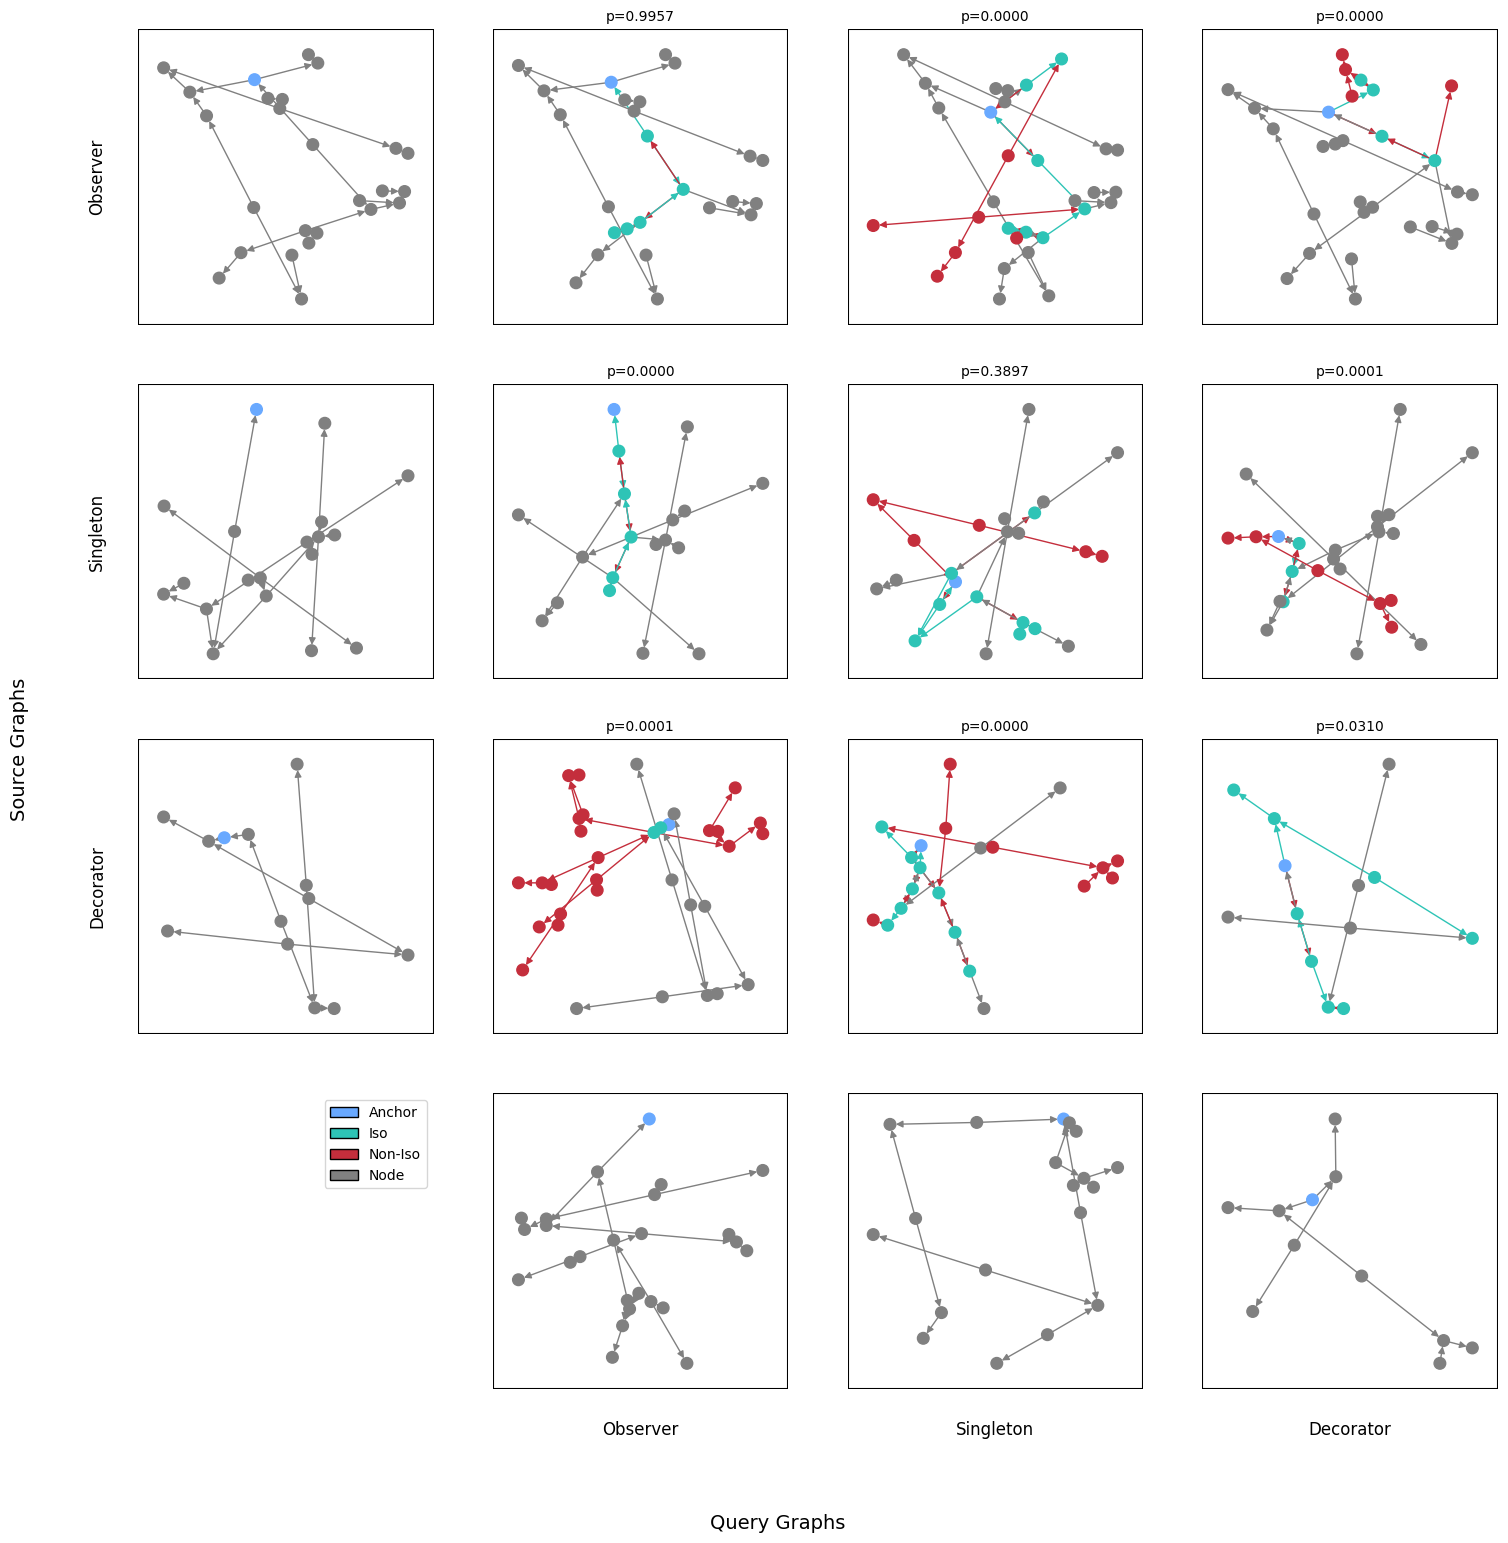

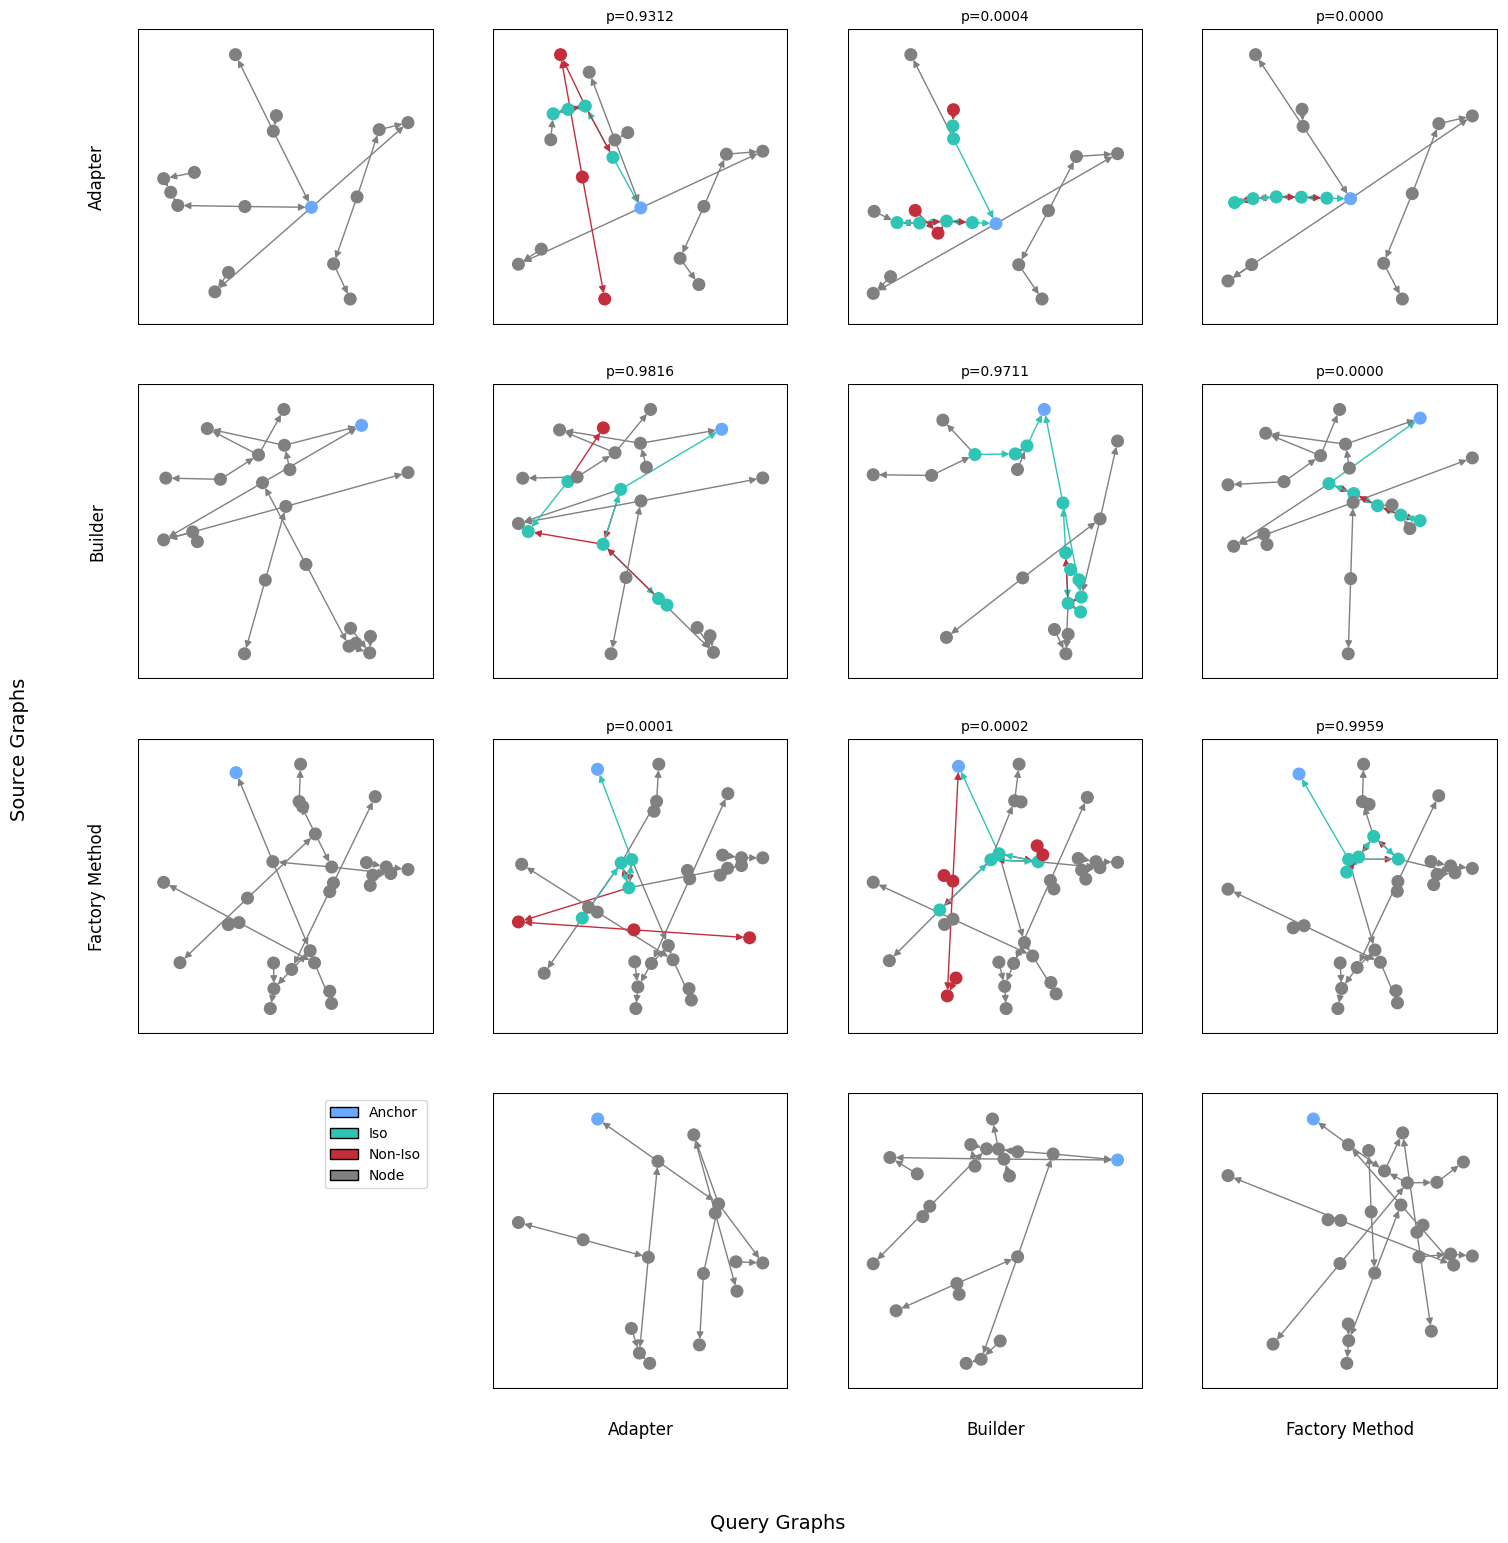

In [32]:
plot_graph_matching( list( DESIGN_PATTERN_MAPPING.keys() )[3:], 
                     matching_examples, 
                     color_legend=color_legend,
                     save_name="matching_examples_3_1" )
plot_graph_matching( list( DESIGN_PATTERN_MAPPING.keys() )[:3], 
                     matching_examples, 
                     color_legend=color_legend,
                     save_name="matching_examples_3_2" )

In [33]:
raise ValueError

ValueError: 

In [ ]:
model = InferenceGNN( args )

In [ ]:
def predict( model, G_source, G_query ) -> float:
    p, (x, y) = model.predict( G_source, G_query )
    return p


def is_subgraph( model: InferenceGNN, G_source, G_query, conf=0.5 ) -> bool:
    p, (x, y) = model.predict( G_source, G_query, conf=conf )
    print( f"query is subgraph of source: {x == 1.0} [{p:.3}]" )
    return x == 1.0

In [ ]:
source_graph_idx = 0
query_subgraph_idx = 5

source = graph_utils.load_source_graph( args, source_graph_idx )
query = graph_utils.load_query_graph( args, source_graph_idx, query_subgraph_idx )
matching_colors = {
    2: "purple",
    1: "green",
    0: "grey",
    -1: "red"
}
combined, node_colors, edge_colors = graph_utils.combine_graph( source, query,
                                                                matching_colors=matching_colors )
plot_utils.plot_graph(
    title="Combined Graph",
    graph=combined,
    nodeColors=node_colors,
    edgeColors=edge_colors,
    #nodeLabels=graph_utils.get_node_labels( combined, **label_args )
)

is_subgraph( model, source, query )

In [ ]:
graph_utils.plot_interactions( args, model, source_graph_idx, query_subgraph_idx, threshold=0.5 )

In [ ]:
source = graph_utils.load_source_graph( args, source_graph_idx, relabel=False )
query = graph_utils.load_query_graph( args, source_graph_idx, query_subgraph_idx, relabel=False )
ground_truth = graph_utils.load_query_id_mapping( args, source_graph_idx, query_subgraph_idx, flip=False )

In [ ]:
interactions = graph_utils.compute_interactions( model, source, query, threshold=0.5 )
interactions

In [ ]:
query_nodes = set( sorted( query.nodes ) )
interaction_query_nodes = set( sorted( [ int( query ) for (query, source) in interactions.keys() ] ) )
print( "query nodes:", query_nodes, f"({len( query_nodes )})" )
print( "interaction query nodes:", interaction_query_nodes, f"({len( interaction_query_nodes )})" )

In [ ]:
source_nodes = set( sorted( source.nodes ) )
interaction_source_nodes = set( sorted( [ int( source ) for (query, source) in interactions.keys() ] ) )
print( "source nodes:", source_nodes, f"({len( source_nodes )})" )
print( "interaction source nodes:", interaction_source_nodes, f"({len( interaction_source_nodes )})" )

In [ ]:
interaction_mappings = graph_utils.map_query_interactions( interactions, query )
interaction_mappings

In [ ]:
ground_truth